<a href="https://colab.research.google.com/github/tjrgh822/class_itsystem/blob/master/hw3/hw3_train_by_data_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from __future__ import print_function
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator


(train_data, train_labels), (test_data, test_labels) = mnist.load_data()


datagen = ImageDataGenerator( width_shift_range=3, 
                             height_shift_range=3, 
                             horizontal_flip=True, 
                             vertical_flip=True,
                             brightness_range = [0.2, 1.0],
                             rotation_range = 90,
                             zoom_range = [0.5, 1.0]
                             )
                      



In [23]:

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

hist_hist, val_hist = [], []


model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(28,28,1), kernel_size=(11,11), padding="valid", activation = "relu"))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation = "relu"))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
model.add(BatchNormalization())
model.add(Dropout(0.3))


# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(units = 2048, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))


# 3rd Fully Connected Layer
model.add(Dense(1024, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(10, activation = "softmax")) #As we have two classes

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
def scheduler(epoch):
  if epoch < 18:
    return 0.0008
  else:
    return 0.0008 * tf.math.exp(0.1 * (18 - epoch))

Lschedule = LearningRateScheduler(scheduler)

batch_size = 100
epochs = 40


checkpointer = ModelCheckpoint(
    filepath=f'last_model.h5',
    save_best_only=True,
)
early_stopping = EarlyStopping(patience=10) #짧게 끊고 싶다면 2로 설정

callbacks=[checkpointer, early_stopping, Lschedule]



hist = model.fit(datagen.flow(train_data.reshape(-1, 28, 28, 1), keras.utils.to_categorical(train_labels, 10), batch_size=batch_size, shuffle= True),
          steps_per_epoch = train_data.shape[0]/ batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=datagen.flow(test_data.reshape(-1, 28, 28, 1), keras.utils.to_categorical(test_labels, 10), batch_size=batch_size, shuffle= False),
          callbacks= callbacks
          )

hist_hist.append(hist)

Epoch 1/40
600/600 [==============================] - 31s 52ms/step - loss: 1.6628 - accuracy: 0.4597 - val_loss: 1.0779 - val_accuracy: 0.6271 - lr: 8.0000e-04
Epoch 2/40
600/600 [==============================] - 31s 52ms/step - loss: 0.9919 - accuracy: 0.6688 - val_loss: 0.7753 - val_accuracy: 0.7392 - lr: 8.0000e-04
Epoch 3/40
600/600 [==============================] - 32s 53ms/step - loss: 0.7731 - accuracy: 0.7429 - val_loss: 0.6900 - val_accuracy: 0.7694 - lr: 8.0000e-04
Epoch 4/40
600/600 [==============================] - 32s 53ms/step - loss: 0.6678 - accuracy: 0.7786 - val_loss: 0.5428 - val_accuracy: 0.8210 - lr: 8.0000e-04
Epoch 5/40
600/600 [==============================] - 31s 52ms/step - loss: 0.6003 - accuracy: 0.8026 - val_loss: 0.4737 - val_accuracy: 0.8441 - lr: 8.0000e-04
Epoch 6/40
600/600 [==============================] - 31s 52ms/step - loss: 0.5557 - accuracy: 0.8171 - val_loss: 0.4697 - val_accuracy: 0.8426 - lr: 8.0000e-04
Epoch 7/40
600/600 [==============

No handles with labels found to put in legend.


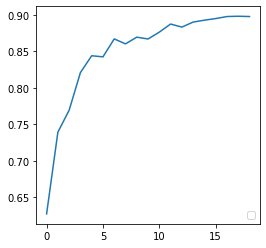

No handles with labels found to put in legend.


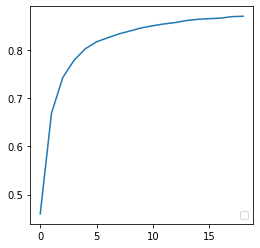

In [24]:

plt.figure(figsize=(4, 4))
plt.plot(hist.history['val_accuracy'])
plt.xlabel('test_acc')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(hist.history['accuracy'])
plt.xlabel('train_acc')
plt.show()

In [25]:
noise_loss_hist = []
noise_acc_hist = []

for i in range(10):
    print(f"~~~~~{i}~~~~~~~~~")
    for k in range(10):
      test_datagen = ImageDataGenerator( width_shift_range= 2* i, 
                                  height_shift_range= 2*i, 
                                  horizontal_flip=True, 
                                  vertical_flip=True,
                                  brightness_range = [0.2, 1.0],
                                  rotation_range = 4*k,
                                  zoom_range = [ 1.0 - 0.8 /10 * i, 1.0 ]
                                  )
      
      val_loss = model.evaluate(test_datagen.flow(test_data.reshape(-1, 28, 28, 1),       
                                                  keras.utils.to_categorical(test_labels, 10),
                                                  batch_size=test_data.shape[0]) 
                                )
      #print(val_loss)
      noise_loss_hist.append([ [i*2], [k*4], [val_loss[0]]])
      noise_acc_hist.append([ [i*2], [k*4], [val_loss[1]] ])



~~~~~0~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.2147 - accuracy: 0.9271
~~~~~1~~~~~~~~~
1/1 [==============================] - 0s 4ms/step - loss: 0.2108 - accuracy: 0.9312
~~~~~2~~~~~~~~~
1/1 [==============================] - 0s 2ms/step - loss: 0.2751 - accuracy: 0.9114
~~~~~3~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 0.5557 - accuracy: 0.8153
~~~~~4~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 1.4424 - accuracy: 0.6147
~~~~~5~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 2.5801 - accuracy: 0.4416
~~~~~6~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 3.4786 - accuracy: 0.3319
~~~~~7~~~~~~~~~
1/1 [==============================] - 0s 2ms/step - loss: 4.0897 - accuracy: 0.2446
~~~~~8~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 4.3507 - accuracy: 0.2020
~~~~~9~~~~~~~~~
1/1 [==============================] - 0s 1ms/step - loss: 4.5627 - accurac

No handles with labels found to put in legend.


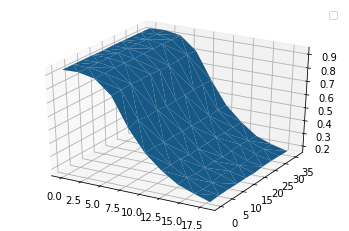

In [26]:


import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np           
import matplotlib.pyplot as plt  

noise_acc_hist = np.squeeze( np.array(noise_acc_hist))

fig = plt.figure()							
ax = fig.gca(projection='3d')
ax.plot_trisurf(noise_acc_hist[:, 0], noise_acc_hist[:, 1], noise_acc_hist[:, 2])	
ax.legend()										

plt.show()

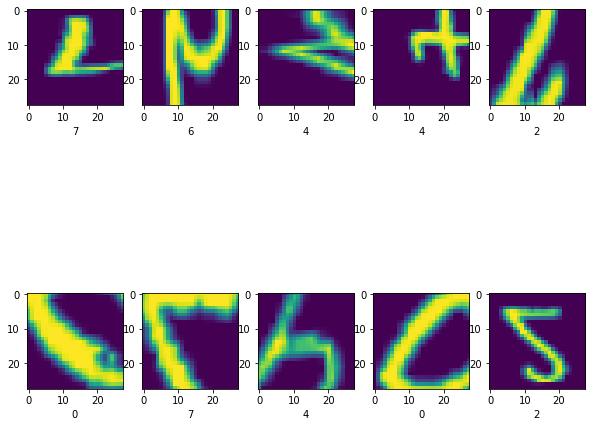

In [27]:

test_datagen = ImageDataGenerator( width_shift_range= 5, 
                            height_shift_range= 5, 
                            horizontal_flip=True, 
                            vertical_flip=True,
                            brightness_range = [0.2, 1.0],
                            rotation_range = 5,
                            zoom_range = [0.2, 1.0]
                            )
x = test_datagen.flow(test_data.reshape(-1, 28, 28, 1),       
                                            keras.utils.to_categorical(test_labels, 10)) 
plt.figure(figsize=(10, 20))

for i in range(10):
  plt.subplot(4, 5, i+1)
  plt.imshow(np.squeeze(x[0][0][i]))
  plt.xlabel(np.argmax(x[0][1][i]))
plt.show()                          

In [28]:
!nvidia-smi

Sun May 31 16:17:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    25W /  75W |   7353MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  